In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_28_5_3_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_45_24_5_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_45_7_1_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_52_10_5_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_52_21_7_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_50_17_2_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_14_19_3_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_50_4_9_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_52_18_14_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_4_5_2_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_26_30_7_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_22_10_3_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_11_15_5_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_20_16_3_all.bmp
/kaggle/input/cnmc-leukemia/fold_0/fold_0/all/UID_4_17_3_all.bmp
/kaggle/input/c

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# VGG16
from keras.applications.vgg16 import VGG16

# To show images
from PIL import Image

In [3]:
# Collect all data into one dataframe
def create_df(dataset):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for filename in filenames:

            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')
                
    df = pd.DataFrame({'Image Path': image_paths, 
                           'Label': labels}) 
    
    return df


train_dir = "/kaggle/input/cnmc-leukemia/fold_0"
df =  create_df(train_dir)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df= train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 2468
Number of test samples: 530
Number of validation samples: 529


In [4]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

In [5]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)  
    y_true = test_gen.classes  
    
    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix 
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)  
    
    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7)) 
    plt.show()

In [6]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy") 
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

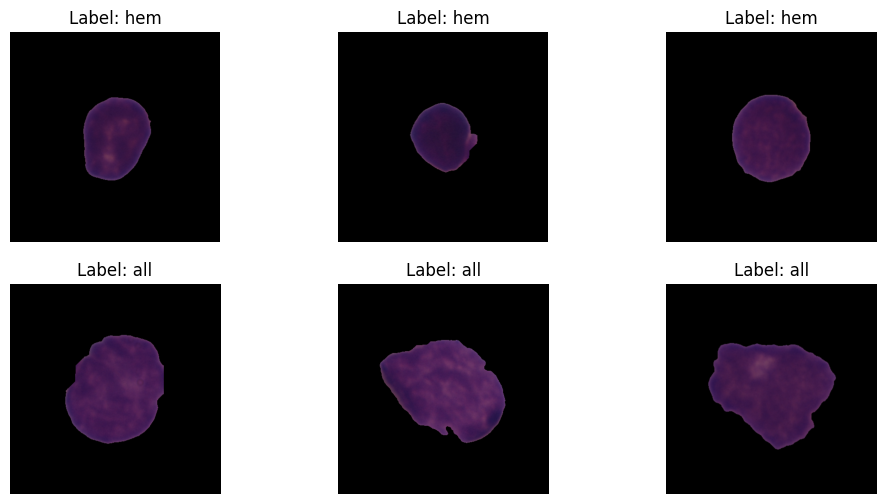

In [7]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')    
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

In [8]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size 

Found 2468 validated image filenames belonging to 2 classes.
Found 529 validated image filenames belonging to 2 classes.
Found 530 validated image filenames belonging to 2 classes.


In [9]:
# Instantiate base model
img_shape=(224, 224, 3)
VGG16_base_model = VGG16(weights='imagenet', input_shape=img_shape, include_top=False, pooling=None)

# Freeze base model to keep pre-trained weights
VGG16_base_model.trainable = False

# Add custom top layers for binary classification
last_layer = VGG16_base_model.get_layer('block5_pool')
last_output = last_layer.output
x = keras.layers.GlobalMaxPooling2D()(last_output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2, activation='sigmoid')(x) 

# Create new model
VGG16_model = tf.keras.Model(VGG16_base_model.input, x, name="VGG16_model")

VGG16_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

VGG16_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,714 (56.14 MB)

 Trainable params: 1,026 (4.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
epochs = 20

history_VGG16 = VGG16_model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=valid_gen,
    validation_steps=validation_steps,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734335697.098179      71 service.cc:145] XLA service 0x7baa7000ba60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734335697.098234      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734335697.098237      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/14 ━━━━━━━━━━━━━━━━━━━━ 4:27 21s/step - accuracy: 0.4000 - loss: 13.9765

I0000 00:00:1734335713.266862      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 30s 686ms/step - accuracy: 0.4837 - loss: 10.8831 - val_accuracy: 0.6519 - val_loss: 4.8284
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 621ms/step - accuracy: 0.5681 - loss: 9.1887 - val_accuracy: 0.6667 - val_loss: 3.6077
Epoch 3/20
 1/14 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.6000 - loss: 6.2716

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5862 - loss: 7.3552 - val_accuracy: 0.6635 - val_loss: 3.7069
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.6373 - loss: 7.6386 - val_accuracy: 0.6667 - val_loss: 1.9713
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.6123 - loss: 6.3847 - val_accuracy: 0.6577 - val_loss: 3.0401
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.5892 - loss: 6.1853 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.6320 - loss: 6.4602 - val_accuracy: 0.6942 - val_loss: 2.4067
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5926 - loss: 6.5695 - val_accuracy: 0.6667 - val_loss: 2.8449
Epoch 9/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.6038 - loss: 5.9933 - val_accuracy: 0.7115 - val_loss: 2.3079
Epoch 10/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5962 - loss: 6.4470 - val_accuracy: 0.8889 - val_lo

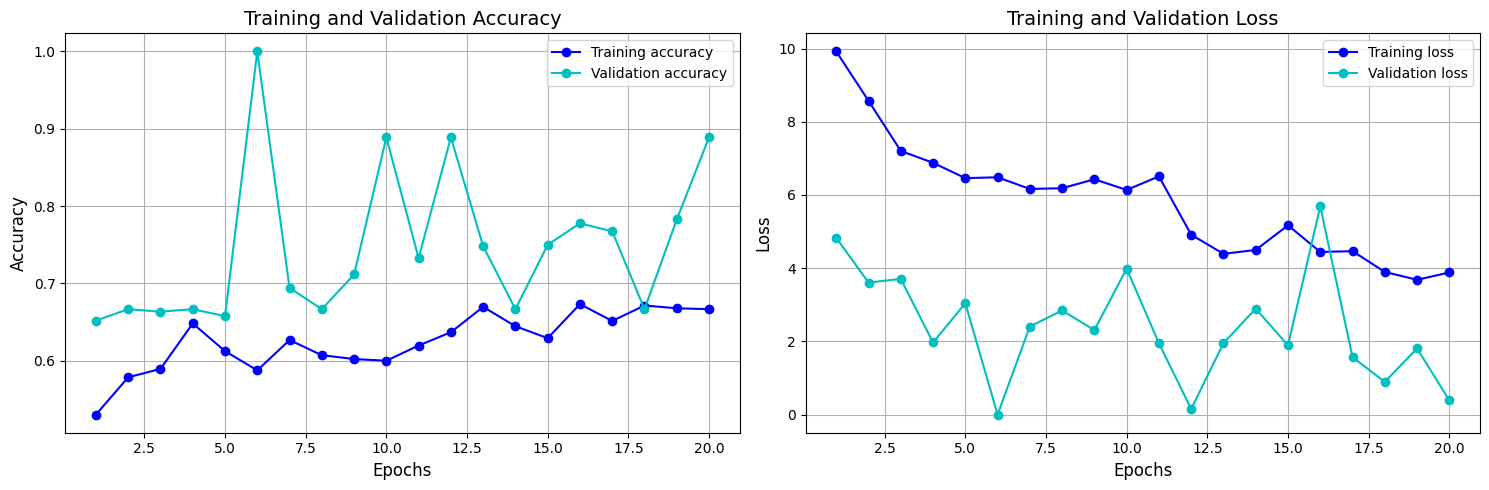

In [11]:
show_history_plot(history_VGG16.history)

In [12]:
evaluation_matrix(VGG16_model)

             Loss       Accuracy  
----------------------------------
Train        1.63965    0.81154   
Validation   1.69041    0.77115   
Test         1.65249    0.79808   


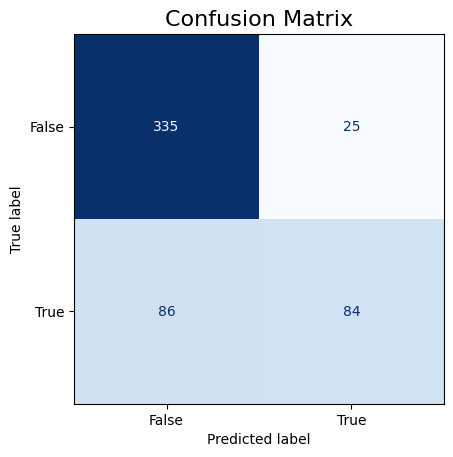

<Figure size 700x700 with 0 Axes>

In [13]:
show_conf_matrix(VGG16_model)